## Data Reduction Pipeline
Let's begin by importing some important modules.

In [78]:
import astropy.units as u
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from matplotlib.gridspec import GridSpec
from helpers import cdelt3, v_to_wavelen, get_uJy_cube
from moment0 import moment0
from specutils_fit import specutils_linear_fit
from data_reduction_functions import data_reduce


# Plotting
We can plot the reduced flux density map using functions in data_reduction.py. Optionally we can plot points that indicate the peak brightnesses or knot locations.

In [72]:
def plot_data_reduce(fits_file, center, moment0_width, fit_width):
    lambda_obs = v_to_wavelen(center, (-77)* u.km/u.s) 
    lambda_obs = center
    print(f"Lambda_obs: {lambda_obs:.5f}")
    # slice = data_reduce(fits_file, lambda_obs, moment0_width, fit_width, center)
    slice = fits.open("../fits/slice2d5.fits")[0].data
    
    fig = plt.figure()
    ax = fig.add_subplot(111, facecolor='black')
    im = ax.imshow(np.log10(slice), origin='lower', cmap='inferno', vmin=0, vmax=4)
    
    ax.set_title(f'Flux Density ($\lambda_0$={center})', fontsize=12)
    ax.set_xlabel('X pixel', fontsize=12)
    ax.set_ylabel('Y pixel', fontsize=12)
    
    cb = plt.colorbar(mappable=im)
    cb.set_label('$\log_{10} F_\lambda \, (\mu Jy)$', fontsize=12)
    
    # Peak brightness locations
    centers_x = [25.26613227,26.13168151, 27.0120717]
    centers_y = [33.59679364, 38.79008904, 44.07243022]
    
    # H2 Knots
    centers_x = [35, 21, 24]
    centers_y = [41, 46, 35]
    colors = ['blue', 'teal', 'palevioletred']
    
    # To plot the centers/peak brightnesses
    # ax.scatter(centers_x, centers_y, c=colors, marker='x', linewidths=3)
    
    plt.tight_layout()
    plt.show()

Lambda_obs: 2.80250 um


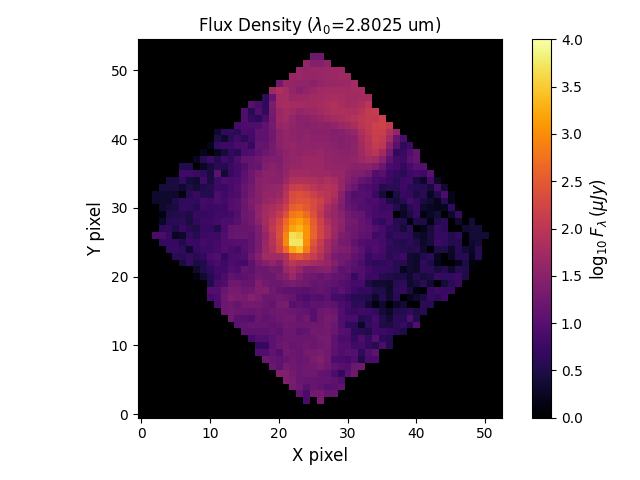

In [73]:
plt.rcParams['figure.dpi'] = 100
plot_data_reduce(fits_file = 'fits/5s3d.fits', center = 2.8025*u.um, moment0_width=0.0015*u.um, fit_width=0.005*u.um)

# Save slice to directory

In [74]:
def write_slice(fits_file, center, moment0_width, fit_width, name='../fits/slice2d.fits'):
    cube = get_uJy_cube(fits_file)
    slice = data_reduce(fits_file, center, moment0_width, fit_width, center)
    
    # Get the 2D WCS (drops spectral axis)
    wcs2d = cube.wcs.sub(['longitude', 'latitude'])

    # Create a FITS header from WCS
    header = wcs2d.to_header()
    
    # Create HDU and save
    hdu = fits.PrimaryHDU(data=slice.value, header=header)
    hdu.writeto(name, overwrite=True)
    print(f"Reduced slice written to file as {name}")

In [75]:
# write_slice(fits_file = 'fits/5s3d.fits', center=2.8025*u.um, moment0_width=0.0015*u.um, fit_width=0.005*u.um, name='fits/slice2d5.fits')

# Plot entire pipeline with intermediate paths
We can now plot each step in the pipeline side by side, which can be useful for publication.

In [76]:
def plot_all(fits_file, center, moment0_width, fit_width):
    # lambda_obs = v_to_wavelen(center, (-29.802)* u.km/u.s) 
    lambda_obs = v_to_wavelen(center, (-77)* u.km/u.s) # velocity adjusted for jet blueshift
    # lambda_obs = center 
    print(f"Lambda_obs: {lambda_obs:.5f}")
    fig = plt.figure(figsize=(15, 4))

    # Create GridSpec: 1 row, 6 columns (moment0, linear fit, subtract, masks, interpolate, colorbar)
    gs = GridSpec(1, 6, width_ratios=[1, 1, 1, 1, 1, 0.1], wspace=0.1)

    # Subplots for the 3 maps
    ax0 = fig.add_subplot(gs[0])
    ax1 = fig.add_subplot(gs[1])
    ax2 = fig.add_subplot(gs[2])
    ax3 = fig.add_subplot(gs[3])
    ax4 = fig.add_subplot(gs[4])
    
    # Colorbar axis
    cax = fig.add_subplot(gs[5])
    
    # Plot moment 0 map
    moment0_slice = moment0(fits_file, lambda_obs, moment0_width)
    im0 = ax0.imshow(np.log10(moment0_slice.value), origin='lower', cmap='inferno', vmin=0, vmax=3)
    ax0.set_title(f'Moment 0 Map', fontsize=13)
    
    
    # Plot the linear fit map
    cont_slice = specutils_linear_fit(fits_file, lambda_obs, fit_width, True) * moment0_width / cdelt3(fits_file)
    im1 = ax1.imshow(np.log10(cont_slice.value), origin='lower', cmap='inferno',vmin=0,vmax=3)
    ax1.set_title(f'Linear Continuum Fit', fontsize=13)
    
    # Plot the subtracted map
    slice = moment0_slice - cont_slice
    
    slice[slice <= 0] = 1e-32 * u.uJy
    im2 = ax2.imshow(np.log10(slice.value), origin='lower', cmap='inferno', vmin = 0,vmax=3)
    ax2.set_title(f'Subtracted Residual', fontsize=13)
    
    # Plot the SNR & manually masked map
    # SNR Mask
    slice = snr_mask(fits_file, slice, lambda_obs)
    # Manual bad spaxel masking
    slice = bad_spaxel_mask(center, slice)
    im3 = ax3.imshow(np.log10(slice.value), origin='lower', cmap='inferno', vmin = 0,vmax=3)
    ax3.set_title(f'SNR & Manual Masked', fontsize=13)
    
    # Interpolate marked spaxels
    slice = interpolate_pixels(slice)
    im4 = ax4.imshow(np.log10(slice.value), origin='lower', cmap='inferno', vmin = 0,vmax=3)
    ax4.set_title(f'Interpolated', fontsize=13)
    
    # Label axes
    ax0.set_ylabel('Y pixel', fontsize=13)
    for ax in [ax0,ax1,ax2,ax3,ax4]:
        ax.set_xlabel('X pixel', fontsize=13)
        ax.set_xticks(np.arange(0, 60, 10)) 
        ax.set_facecolor('black')
    for ax in [ax1,ax2,ax3,ax4]:
        ax.set_yticks([]) # removes extra tick labels
    
    # Add colorbar in its own axis
    fig.colorbar(im0, cax=cax, label=r'$\log_{10} F_\lambda \, (\mu Jy)$')
    # fig.suptitle(f"$\lambda_0$={center}", fontsize=14)
    fig.subplots_adjust(top=0.88, bottom=0.3)
    plt.tight_layout()
    plt.show()

Lambda_obs: 1.64358 um


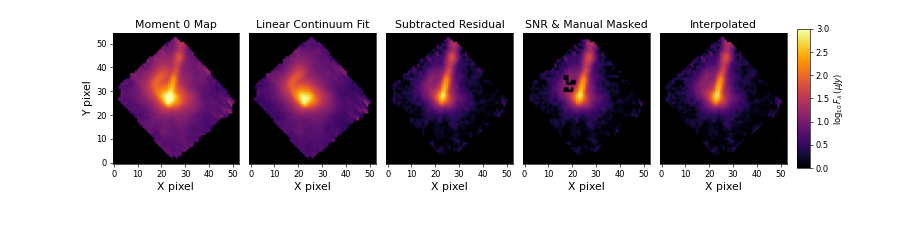

In [77]:
import warnings
warnings.filterwarnings('ignore') # ignores the warning messages

plt.rcParams['figure.dpi'] = 60 # Changes widget size
plot_all(fits_file = '../fits/4s3d.fits', center = 1.644*u.um, moment0_width=0.0015*u.um, fit_width=0.005*u.um)